<h1> Battle of the neighborhoods</h1>

## Table of contents
* [Introduction: Business Problem](#introduction)

* [Data](#data)

* [Collecting and Tabulating Data](#Collecting)

* [Methodology](#methodology)

* [Analysis](#analysis)

* [Results and Discussion](#results)

* [Conclusion](#conclusion)

<h3>Introduction/ Business Problem</h3> <a name = "introduction"> </a>

Finding the right location to open a **supplement store** in Manhattan, NYC is crucial to the success of supplement store franchises looking to expand. 

Many sports enthusiasts and gym goers from various ethnicities reside in  New York. With a population north of 8 million, this is a prime city for business. 

The **right location** to open up a supplement store would be one where sports enthusiasts and gym goers are more likely to be found AND no supplement shops are found in close vicinity.

<h3>Data</h3><a name = "data"></a>

Location data can be extracted using Foursquare’s API and this json file.
Density of existing supplement shop densities have to be taken into consideration to avoid competition which would affect revenue.
 We also require the locations of the following venues to clearly define the right location to open a supplement store:

<ul>
    <li>Athletics & Sports Venues, 
     <li>   Baseball Fields,
    <li>	Basketball Courts,
      <li>  Boxing Gyms,  
       <li> Climbing Gyms,
    <li>	Cycle Studios,
      <li>  Gyms, Gym/Fitness Centers, Gym Pools,
       <li> Soccer Fields,
       <li> Sports clubs, Sporting Goods Shops
        <li>Tennis courts
</ul>

Additionally, we'll include supplement shops as well


Importing libraries

In [4]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


<h1> Collecting and Tabulating Data </h1> <a name = "Collecting"></a> 

We'll analyse all 5 boroughs and 306 neighborhoods of NYC and tabulate them from this json file >  https://geo.nyu.edu/catalog/nyu_2451_34572 

We'll use Foursquare's API to analyse the venues in each neighborhood

Loading the data

In [5]:
with open('ny_geojson.json') as json_data:
    newyork_data = json.load(json_data)

In [41]:
df = newyork_data['features']

In [42]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [43]:
for data in df:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [44]:
neighborhoods.shape

(306, 4)

In [45]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan']

Exploring venues

In [46]:
CLIENT_ID = 'HQYFRIKBBCCYM2PEQKLONY2UTVQULYS2DKMQ5JQTZSUEIEBW' # your Foursquare ID
CLIENT_SECRET = 'QRPHFK3JWDIMK2W1TM4T5P4G5Y2KU55Q5N3WLLMC53R5X3XV' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: HQYFRIKBBCCYM2PEQKLONY2UTVQULYS2DKMQ5JQTZSUEIEBW
CLIENT_SECRET:QRPHFK3JWDIMK2W1TM4T5P4G5Y2KU55Q5N3WLLMC53R5X3XV


<h5>We'll be analysing Manhattan; Let's extract all venues in Manhattan</h5>

In [47]:
address = 'Manhattan ,NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
manhattan_latitude = location.latitude
manhattan_longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(manhattan_latitude, manhattan_longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


In [48]:
# type your answer here
LIMIT = 500
radius = 1000
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID,CLIENT_SECRET,manhattan_latitude,manhattan_longitude,VERSION,radius,LIMIT )
url

'https://api.foursquare.com/v2/venues/explore?client_id=HQYFRIKBBCCYM2PEQKLONY2UTVQULYS2DKMQ5JQTZSUEIEBW&client_secret=QRPHFK3JWDIMK2W1TM4T5P4G5Y2KU55Q5N3WLLMC53R5X3XV&ll=40.7896239,-73.9598939&v=20180605&radius=1000&limit=500'

In [49]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [50]:
# Exploring all neighborhoods in a Borough
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Number of venues

In [19]:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )



Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


In [51]:
print('There are {} uniques categories.'.format(len(manhattan_venues['Venue Category'].unique())))

There are 328 uniques categories.


Creating a map of Manhattan

In [76]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[manhattan_latitude, manhattan_longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

## Analyzing each neighborhood

We'll analyse each venue and filter out the sports related venues

In [52]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cambodian Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack 

### Creating column list of all venues that sports enthusiasts and gym goers frequent
We'll include other supplement shops as well to assess competition 

In [53]:
column_list = ['Neighborhood','Supplement Shop','Athletics & Sports','Baseball Field','Basketball Court','Boxing Gym','Gym','Cycle Studio', 'Gym / Fitness Center', 'Gym Pool','Soccer Field', 'Sports Club', 'Sporting Goods Shop','Tennis Court']

In [54]:
manhattan_sports = manhattan_onehot[[*column_list]]

In [55]:
manhattan_sports.head()

,Neighborhood,Supplement Shop,Athletics & Sports,Baseball Field,Basketball Court,Boxing Gym,Gym,Cycle Studio,Gym / Fitness Center,Gym Pool,Soccer Field,Sports Club,Sporting Goods Shop,Tennis Court
0,Marble Hill,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Marble Hill,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Marble Hill,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Marble Hill,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Marble Hill,0,0,0,0,0,0,0,0,0,0,0,0,0


In [56]:
manhattan_grouped = manhattan_sports.groupby('Neighborhood').mean().reset_index()
manhattan_grouped.head()

,Neighborhood,Supplement Shop,Athletics & Sports,Baseball Field,Basketball Court,Boxing Gym,Gym,Cycle Studio,Gym / Fitness Center,Gym Pool,Soccer Field,Sports Club,Sporting Goods Shop,Tennis Court
0,Battery Park City,0.0,0.015873,0.0,0.0,0.0,0.047619,0.000000,0.000000,0.0,0.0,0.00,0.0,0.0
1,Carnegie Hill,0.0,0.000000,0.0,0.0,0.0,0.034091,0.000000,0.034091,0.0,0.0,0.00,0.0,0.0
2,Central Harlem,0.0,0.000000,0.0,0.0,0.0,0.021739,0.021739,0.043478,0.0,0.0,0.00,0.0,0.0
3,Chelsea,0.0,0.000000,0.0,0.0,0.0,0.010000,0.020000,0.000000,0.0,0.0,0.00,0.0,0.0
4,Chinatown,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.01,0.0,0.0




This concludes our data collection stage.

# Methodology<a name = "methodology"></a>

We'll analyse each neighborhood and take a **mean** of all sports facilities to quantify the **concentration** of  each sports facility in each neighborhood. 

We have ignored all stadiums and other facilities which are used infrequently throughout the year and are reserved for tournaments.

Further, we'll sum all column mean values to get a value on the **total** sports facility concentration in **each** neighborhood. This step will exclude supplement shops.

Afterwards, we'll use the **KMeans** Machine Learning algorithm to cluster neighborhoods based on the sports facilities and supplement shops present. The **elbow method** will be deployed to calculate the optimal k value.

We'll proceed to analyse each cluster individually for further analysis.


### Let's sum all the columns to get a value on the concentration of sports venues in each neighborhood

Excluding supplement shops

In [57]:
manhattan_grouped['Sum'] = manhattan_grouped.iloc[:,1:].sum(axis = 1)
manhattan_grouped.sort_values(by = 'Sum',ascending = False)

,Neighborhood,Supplement Shop,Athletics & Sports,Baseball Field,Basketball Court,Boxing Gym,Gym,Cycle Studio,Gym / Fitness Center,Gym Pool,Soccer Field,Sports Club,Sporting Goods Shop,Tennis Court,Sum
10,Flatiron,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.020000,0.070000,0.000000,0.000000,0.01,0.020000,0.000000,0.160000
14,Hudson Yards,0.000000,0.017544,0.000000,0.000000,0.000000,0.035088,0.017544,0.052632,0.000000,0.000000,0.00,0.000000,0.000000,0.122807
22,Marble Hill,0.040000,0.000000,0.000000,0.000000,0.000000,0.080000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.120000
28,Roosevelt Island,0.000000,0.000000,0.000000,0.000000,0.000000,0.038462,0.000000,0.038462,0.000000,0.038462,0.00,0.000000,0.000000,0.115385
30,Stuyvesant Town,0.000000,0.000000,0.055556,0.000000,0.000000,0.000000,0.000000,0.055556,0.000000,0.000000,0.00,0.000000,0.000000,0.111111
5,Civic Center,0.000000,0.000000,0.000000,0.000000,0.010309,0.020619,0.000000,0.051546,0.000000,0.000000,0.00,0.020619,0.000000,0.103093
16,Lenox Hill,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,0.020000,0.030000,0.000000,0.000000,0.00,0.020000,0.000000,0.100000
6,Clinton,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,0.050000,0.000000,0.000000,0.00,0.010000,0.000000,0.100000
31,Sutton Place,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,0.040000,0.000000,0.000000,0.00,0.010000,0.010000,0.100000
39,Yorkville,0.000000,0.010000,0.000000,0.000000,0.000000,0.060000,0.000000,0.010000,0.000000,0.010000,0.00,0.000000,0.000000,0.090000


Let's create the dataframe for clustering

In [92]:
manhattan_sports_clustering = manhattan_grouped[['Neighborhood','Sum','Supplement Shop']]
manhattan_sports_clustering.shape

(40, 3)

# Clustering

Calculating the optimal value of k

In [94]:
sum_of_squared_distances = []
K = range(1,12)
for val in K:
    kmeans = KMeans(n_clusters=val)
    kmeans = kmeans.fit(manhattan_sports_clustering[['Sum','Supplement Shop']])
    sum_of_squared_distances.append(kmeans.inertia_)

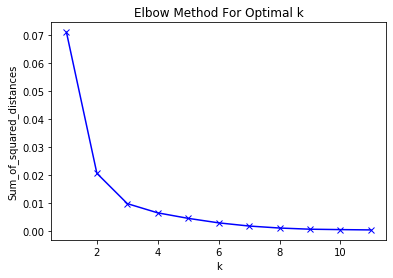

In [95]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

### The optimal value of the number of clusters is 3

In [96]:
# # set number of clusters
kclusters = 3

manhattan_grouped_clustering = manhattan_sports_clustering.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=3, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
klabels = kmeans.labels_

In [111]:
# manhattan_sports_clustering.insert(0, 'Cluster Labels', klabels)

manhattan_merged = manhattan_data.reset_index(drop = True)
manhattan_merged = manhattan_merged.join(manhattan_sports_clustering.set_index('Neighborhood'),on= 'Neighborhood')
manhattan_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Sum,Supplement Shop
0,Manhattan,Marble Hill,40.876551,-73.910660,0,0.12000,0.040000
1,Manhattan,Chinatown,40.715618,-73.994279,1,0.01000,0.000000
2,Manhattan,Washington Heights,40.851903,-73.936900,2,0.05814,0.011628
3,Manhattan,Inwood,40.867684,-73.921210,1,0.00000,0.000000
4,Manhattan,Hamilton Heights,40.823604,-73.949688,1,0.00000,0.000000


# Let's have a look at the clusters visually overlayed on the map

In [112]:
# create map
map_clusters = folium.Map(location=[manhattan_latitude, manhattan_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Analysis<a name = "analysis"></a>

We have successfully calculated the right value of k and used it to form clusters of neighborhoods.

Let's have a look at each group of clusters

Cluster 0

In [100]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,Sum,Supplement Shop
0,Marble Hill,0.120000,0.04
6,Central Harlem,0.086957,0.00
9,Yorkville,0.090000,0.00
10,Lenox Hill,0.100000,0.00
11,Roosevelt Island,0.115385,0.00
14,Clinton,0.100000,0.00
32,Civic Center,0.103093,0.00
34,Sutton Place,0.100000,0.00
37,Stuyvesant Town,0.111111,0.00
38,Flatiron,0.160000,0.00


Cluster 1

In [101]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,Sum,Supplement Shop
1,Chinatown,0.010000,0.0
3,Inwood,0.000000,0.0
4,Hamilton Heights,0.000000,0.0
5,Manhattanville,0.000000,0.0
7,East Harlem,0.024390,0.0
12,Upper West Side,0.022727,0.0
17,Chelsea,0.030000,0.0
18,Greenwich Village,0.020000,0.0
19,East Village,0.000000,0.0
20,Lower East Side,0.020000,0.0


Cluster 2

In [106]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,Sum,Supplement Shop
2,Washington Heights,0.058140,0.011628
8,Upper East Side,0.057471,0.000000
13,Lincoln Square,0.084211,0.000000
15,Midtown,0.080000,0.000000
16,Murray Hill,0.063158,0.000000
21,Tribeca,0.064103,0.000000
23,Soho,0.040000,0.000000
28,Battery Park City,0.063492,0.000000
29,Financial District,0.050000,0.000000
30,Carnegie Hill,0.068182,0.000000


### Results and Discussion<a name = 'results'></a>

Analysing each cluster reveals that clusters 0 and 2 have a significant portion of sports facilities and closer inspection reveals that cluster 0 has a siginificant chunk of sports facilities.

Meanwhile, cluster 1 has to be avoided like the plague as it has very few sports facilities; therefore, it's in the best interest of stakeholders to avoid cluster 1 and focus on cluster 0.

### Let's analyse cluster 0

In [69]:
CLUSTER_0 = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
CLUSTER_0.sort_values(by = 'Sum',ascending = False)

,Neighborhood,Sum,Supplement Shop
38,Flatiron,0.160000,0.00
39,Hudson Yards,0.122807,0.00
0,Marble Hill,0.120000,0.04
11,Roosevelt Island,0.115385,0.00
37,Stuyvesant Town,0.111111,0.00
32,Civic Center,0.103093,0.00
10,Lenox Hill,0.100000,0.00
14,Clinton,0.100000,0.00
34,Sutton Place,0.100000,0.00
9,Yorkville,0.090000,0.00


Clearly, Flatiron and Hudson Yards hve the highest concentrations of sports facilities and surprisingly, no supplement shops.
It would be ideal to focus on the neighborhoods on the list above for further inspection.

# Conclusion<a name = 'conclusion'></a>

This capstone project is a part of the IBM Data Science Professional Course.

The purpose of this project is to extract meaningful data about Manhattan, NYC and apply data science techniques to identify the right locations to open up a shop.

The neighborhood data was collected from the web and the venues frequented by sports enthusiasts and gym goers were collected from Foursquare's API and put together in a dataframe. 

Final decision has to be taken by stakeholders to determine which of the locations described above are ideal depending on the vicinity of the surroundings itself.
